<a href="https://colab.research.google.com/github/ngotancuong/PythonAssignment/blob/main/Baitap01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI HƯỚNG DẪN TÌM HIỂU VỀ EDA, PHÂN TÍCH DỮ LIỆU CHUỖI THỜI GIAN VÀ CÁC DỰ BÁO DỰA VÀO MÔ HÌNH SARIMAX

Cuộc thi này do Walmart tài trợ có tên là Dự báo M5. Sử dụng dữ liệu bao gồm khoảng 30.000 mặt hàng khác nhau trong gần 1900 ngày. Mục tiêu là dự báo doanh số bán hàng trong 28 ngày tới. Phân bố ở ba Tiểu bang Hoa Kỳ (California, Texas và Wisconsin).

Đầu tiên phải load data mẫu từ Kaggle về project này để chạy

In [1]:
# Cài đặt package Kaggle hỗ trợ kết nối Colab với Kaggle
!pip install -q kaggle

In [2]:
# Download file Kaggle API Token cho phép kết nối vào tài nguyên Kaggle
!wget 'https://raw.githubusercontent.com/ngotancuong/PythonAssignment/main/kaggle.json'

# Cách khác nếu đã download file kaggle.json về máy tính rồi thì dùng lệnh sau để upload thủ công lên Colab
# from google.colab import files
# files.upload()

--2022-10-19 18:40:03--  https://raw.githubusercontent.com/ngotancuong/PythonAssignment/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2022-10-19 18:40:03 (2.98 MB/s) - ‘kaggle.json’ saved [63/63]



In [3]:
# Bắt buộc file kaggle.json phải được đặt tại đường dẫn ~/.kaggle/kaggle.json để dùng API
# Tạo thư mục
!mkdir ~/.kaggle

In [4]:
# Copy file kaggle.json vào thư mục quy định
!cp kaggle.json ~/.kaggle/

In [5]:
# Phân quyền trên file là Owner được read & write
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# List 1 số datasets thông dụng trên Kaggle
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           4092        127  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           3398         98  1.0              
thedevastator/fast-food-restaurants-in-the-united-states        Fast Food Restaurants in the United States            4MB  2022-10-08 17:30:38           1171         32  1.0              
whenamancodes/students-performance-in-exams                 

Nếu không thấy dataset mình cần thì tìm trực tiếp trên Kaggle. Vào mục Data như hình, copy code thực thi
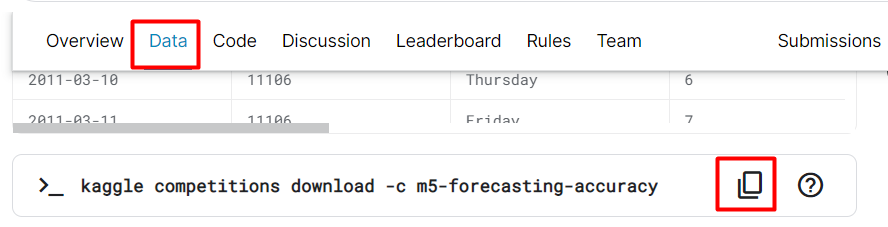

In [7]:
# Tiến hành download dataset về Colab
!kaggle competitions download -c m5-forecasting-accuracy

 74% 34.0M/45.8M [00:00<00:00, 186MB/s]
100% 45.8M/45.8M [00:00<00:00, 171MB/s]


In [22]:
#Tạo folder chứa dataset, thông số -p -v để tạo folder cha và con
!mkdir -p -v /kaggle/input/m5-forecasting-accuracy

mkdir: created directory '/kaggle'
mkdir: created directory '/kaggle/input'
mkdir: created directory '/kaggle/input/m5-forecasting-accuracy'


In [23]:
# Giải nén file datatset vào folder
!unzip  m5-forecasting-accuracy.zip -d "/kaggle/input/m5-forecasting-accuracy"
# Hoàn thành xong bước chuẩn bị dữ liệu

Archive:  m5-forecasting-accuracy.zip
  inflating: /kaggle/input/m5-forecasting-accuracy/calendar.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sample_submission.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sell_prices.csv  


# Import các thư viện cần thiết

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv


#### Mô tả các Dataset:

Các file dataset đã import vào có những nội dung như sau

* `calendar_df.csv` - Chứa thông tin về ngày sản phẩm được bán và cũng chứa thông tin về các ngày lễ và các dịp đặc biệt.
* `train_sales_df.csv` - Chứa dữ liệu lịch sử bán hàng hàng ngày tại từng cửa hàng trong khoảng 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Những file submit đúng định dạng, bao gồm product ids, column ids cho việc dự báo doanh thu bán hàng 28 ngày kế tiếp. 
* `sell_prices_df.csv` - Bao gồm thông tin về giá sản phẩm được bán tại từng cửa hàng mỗi ngày.
* `sales_train_evaluation.csv` - Bao gồm doanh số [d_1 - d_1941] (dùng cho việc khen thưởng, tuyên dương nhân viên)